In [52]:
import pandas as pd
import glob
from pathlib import Path
from nilearn import image, plotting
import nibabel as nib

bids_dir = Path('/data/ds-retsupp')
sourcedata = bids_dir / 'sourcedata' / 'mri'

subject = 1
session = 1
source_dir = sourcedata / f'sub-{subject:02d}' / f'ses-{session}'
target_dir = bids_dir / f'sub-{subject:02d}' / f'ses-{session}'
target_dir.mkdir(parents=True, exist_ok=True)

In [53]:
source_dir

PosixPath('/data/ds-retsupp/sourcedata/mri/sub-01/ses-1')

In [ ]:
# Find anatomical data
(target_dir / 'anat').mkdir(parents=True, exist_ok=True)

#T1w
t1w_candidates = list(source_dir.glob('*MP2_085mm*_1.PAR'))
print(f'Found {len(t1w_candidates)} T1w candidates')

assert(len(list(t1w_candidates)) == 1), f'Expected 1 T1w candidate, found {len(list(t1w_candidates))}'
t1w = list(t1w_candidates)[0]

# Convert to NIfTI
img = nib.load(t1w)
t1w_nii = nib.Nifti1Image(img.dataobj, img.affine)
t1w_nii = image.index_img(t1w_nii, 0)
t1w_nii = image.math_img('np.where(img == img.max(), 0, img)', img=t1w_nii)
t1w_nii.to_filename(target_dir / 'anat' / f'sub-{subject:02d}_ses-{session}_T1w.nii.gz')

# T2w
t2w_candidates = list(source_dir.glob('*T2w*.PAR'))
print(f'Found {len(t2w_candidates)} T2w candidates')
assert(len(t2w_candidates) == 1), f'Expected 1 T2w candidate, found {len(list(t2w_candidates))}'
t2w = list(t2w_candidates)[0]

# Convert to NIfTI
t2w_nii = image.load_img(t2w)
t2w_nii = nib.Nifti1Image(t2w_nii.dataobj, t2w_nii.affine)
t2w_nii = image.math_img('np.where(img == img.max(), 0, img)', img=t2w_nii)
t2w_nii.to_filename(target_dir / 'anat' / f'sub-{subject:02d}_ses-{session}_T2w.nii.gz')


Found 1 T1w candidates
Found 1 T2w candidates


In [96]:
default_json = {
  "Manufacturer": "Philips",
  "ManufacturersModelName": "Ingenia",
  "MagneticFieldStrength": 7,
  "ReceiveCoilName": ["SENSE-Head-7T-Ant", "SENSE-Head-7T-Post"],
  "FlipAngle": 66,
  "EchoTime": 0.024,
  "RepetitionTime": 1.6,
  "SliceThickness": 1.7,
  "VoxelSize": [1.68, 1.68, 1.7],
  "FieldOfView": [215, 215, 137.7],
  "MultibandAccelerationFactor	": 3,
  "ParallelReductionFactorInPlane": 2.4,
  "FatSuppressionTechnique": "SPIR",
  "MRAcquisitionType": "3D",
  "PulseSequenceType": "EPI",
  "PartialFourier": 0.796610177,
  "PhaseEncodingDirection":"j",
  "TotalScanDuration": "07:05.6",
  "TotalReadoutTime": 0.027578312
}

In [98]:
# Find functional data
import re
import json

(target_dir / 'func').mkdir(parents=True, exist_ok=True)

# Find all functional runs
func_candidates = list(source_dir.glob('*_func-bold_task_run-*.PAR'))

reg = re.compile(r'(?P<task>task-[a-zA-Z0-9_]+)_run-(?P<run>[0-9]+)')

for func_candidate in func_candidates:
    # Convert to NIfTI
    func_nii = image.load_img(func_candidate)
    func_nii = nib.Nifti1Image(func_nii.dataobj, func_nii.affine)
    func_nii_magnitude = image.index_img(func_nii, slice(0, int(func_nii.shape[-1]/2)))
    func_nii_phase = image.index_img(func_nii, slice(int(func_nii.shape[-1]/2), func_nii.shape[-1]))
    reg = re.compile(r'run-(?P<run>[0-9]+)')
    run = int(reg.search(func_candidate.name).group('run'))

    # Save magnitude and phase images
    func_nii_magnitude.to_filename(target_dir / 'func' / f'sub-{subject:02d}_ses-{session}_task-search_run-{run}_part-mag_bold.nii.gz')
    func_nii_phase.to_filename(target_dir / 'func' / f'sub-{subject:02d}_ses-{session}_task-search_run-{run}_part-phase_bold.nii.gz')

    with open(target_dir / 'func' / f'sub-{subject:02d}_ses-{session}_task-search_run-{run}_part-mag_bold.json', 'w') as f:
        json.dump(default_json, f, indent=2)

    with open(target_dir / 'func' / f'sub-{subject:02d}_ses-{session}_task-search_rec-NORDIC_run-{run}_bold.json', 'w') as f:
        json.dump(default_json, f, indent=2)


# B1 maps

In [113]:
(target_dir / 'func').mkdir(parents=True, exist_ok=True)

# Finall B- maps
bmap_candidates = list(source_dir.glob('*fmap-B0*.PAR'))

n_bmap_candidates = len(bmap_candidates)

assert n_bmap_candidates in [2], f'Expected 1 or 2 B0 candidates, found {n_bmap_candidates}'

for ix, bmap in enumerate(bmap_candidates):
    bmap_nii = image.load_img(bmap)
    bmap_nii = nib.Nifti1Image(bmap_nii.dataobj, bmap_nii.affine)

    bmap_magnitude = image.index_img(bmap_nii, 0)
    bmap_phase = image.index_img(bmap_nii, 1)

    json_bmap = {'EchoTime1': 0.0,
                'EchoTime2': 0.0045,}

    json_bmap['IntendedFor'] = [f'ses-{session}/func/sub-{subject:02d}_ses-{session}_task-search_rec-NORDIC_run-{run}_bold.nii.gz' for run in range(1 + ix*3, 4 + ix*3)]

    bmap_magnitude.to_filename(target_dir / 'fmap' / f'sub-{subject:02d}_ses-{session}_run-{ix+1}_magnitude1.nii.gz')
    bmap_phase.to_filename(target_dir / 'fmap' / f'sub-{subject:02d}_ses-{session}_run-{ix+1}_phasediff.nii.gz')

    with open(target_dir / 'fmap' / f'sub-{subject:02d}_ses-{session}_run-{ix+1}_magnitude1.json', 'w') as f:
        json.dump(json_bmap, f, indent=2)

    with open(target_dir / 'fmap' / f'sub-{subject:02d}_ses-{session}_run-{ix+1}_phasediff.json', 'w') as f:
        json.dump(json_bmap, f, indent=2)

In [ ]:
dir(image.load_img(bmap).)

AttributeError: 'PARRECHeader' object has no attribute 'raw_data_from_fileobj'

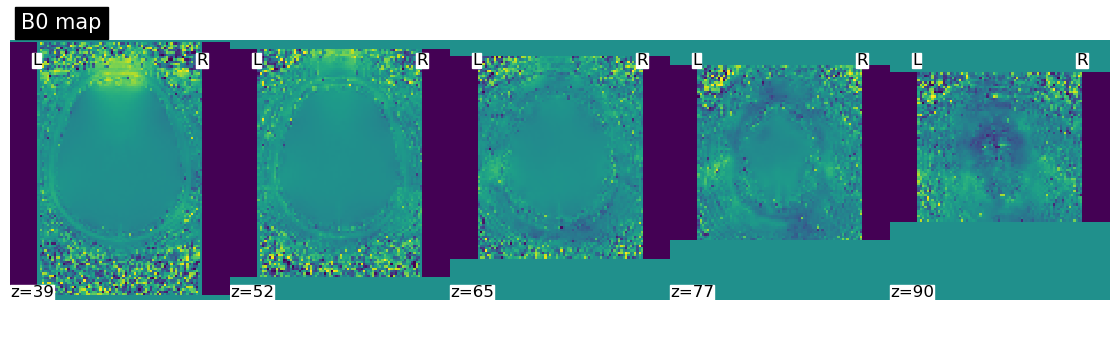

In [104]:
plotting.plot_img(image.index_img(bmap_nii, 1), title='B0 map', display_mode='z', cut_coords=5)

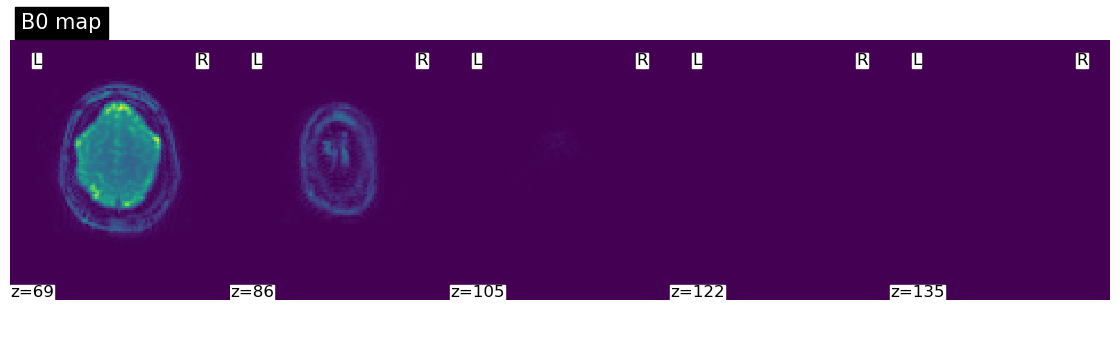

In [103]:
plotting.plot_img(image.index_img(bmap_nii, 0), title='B0 map', display_mode='z', cut_coords=5)

In [ ]:
match = reg.search(func.name).group(1)
match

'01'

In [80]:
reg.findall(func.name)

[]

In [71]:
func_nii_magnitude.shape

(128, 128, 81, 263)

In [72]:
func_nii_phase.shape

(128, 128, 81, 263)

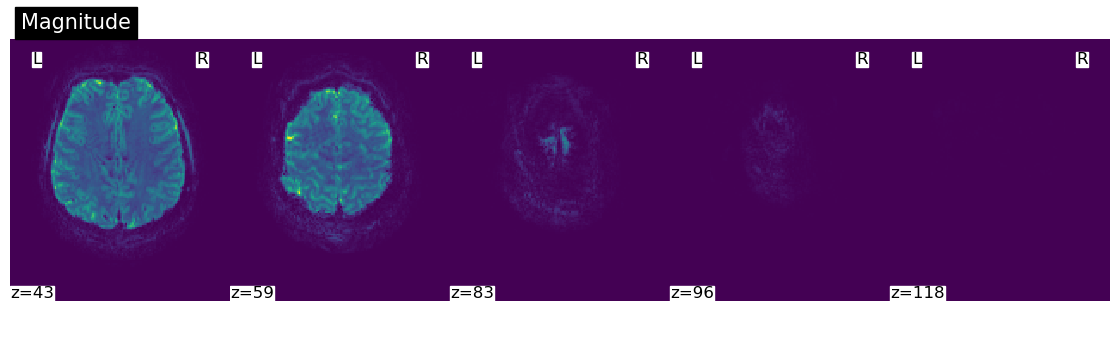

In [73]:
plotting.plot_img(image.index_img(func_nii_magnitude, 262), title='Magnitude', display_mode='z', cut_coords=5)

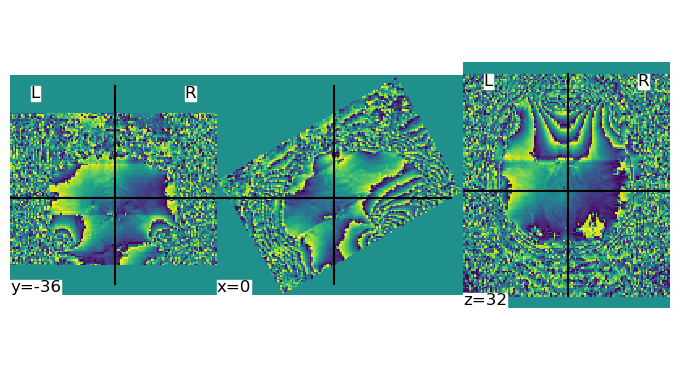

In [76]:
plotting.plot_img(image.index_img(func_nii_phase, 1),)

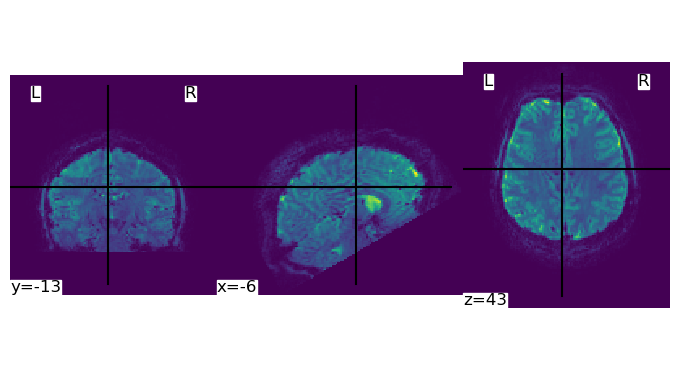

In [69]:
plotting.plot_img(image.index_img(func_nii, int(526/2)- 1))

In [58]:
# Get fieldmaps

(target_dir / 'fmap').mkdir(parents=True, exist_ok=True)

# Find fieldmap data
fmap_candidates = list(source_dir.glob('*fmap-B0*.PAR'))
list(fmap_candidates)

[PosixPath('/data/ds-retsupp/sourcedata/mri/sub-01/ses-1/RetSup_test1_fmap-B0_acq-phdiff_run-1_8_1.PAR'),
 PosixPath('/data/ds-retsupp/sourcedata/mri/sub-01/ses-1/RetSup_test1_fmap-B0_acq-phdiff_run-2_14_1.PAR')]

In [28]:
data = image.index_img(nii_img, 0).get_fdata()

In [30]:
data.max()

499.99909

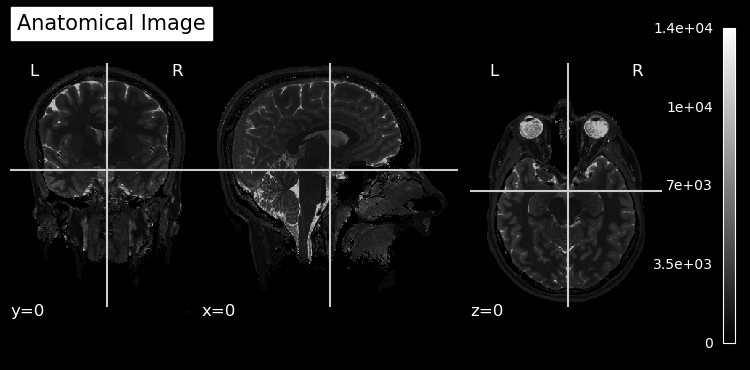

In [27]:
plotting.plot_anat(image.index_img(nii_img, 1), title='Anatomical Image', display_mode='ortho', cut_coords=(0, 0, 0), colorbar=True)

# Anatomicals

PARRECError: Cannot create PARRECHeader from air.

In [ ]:
plotting.plot_img(image.index_img(im, 0), title='PAR file', display_mode='ortho', cut_coords=(0, 0, 0))a

PARRECError: Cannot create PARRECHeader from air.

In [8]:
source_dir.exists()

True